<a href="https://colab.research.google.com/github/Ansi4Ansi/Google_colab/blob/main/ML_B2C_2024_Q2_%7C_HW08_ML_generative_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #8: Генеративный ИИ

**Оформление ДЗ**:

- Выполненное ДЗ сохраните в файл ``ml_b2c2024q2_<Surname>_<Name>_HW#.ipynb``
  
  (пример ``ml_b2c2024q2__Dral_Alexey_HW01.ipynb``)
- Зарегистрироваться и залогиниться в сервисе [Everest](https://everest.distcomp.org/)
- Перейти на страницу приложения: [BDT-grader-ML-B2C](https://everest.distcomp.org/apps/BigDataTeam/BDT-grader-ML-B2C)
- Выбрать вкладку Submit Job (если отображается иная).
- Выбрать в качестве “Task” значение: `` ML_generative_ai`` (кодовое название для преподвателей: `` ML_generative_ai``)
- Загрузить в качестве “Task solution” файл с решением
- В качестве Access Token указать тот, который был выслан по почте или в телеграм от аккаунта @bdt_manager

**Дополнительные ссылки**
- Настройка локального окружения: https://github.com/big-data-team/ml-course
- Датасеты UCI: https://archive.ics.uci.edu/

**Вопросы**:
- Свои вопросы присылайте в Телеграм.

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по сссылке:

    https://forms.gle/iY5NRn9UfaZ344rbA

## Вопросы на понимание (10%)

1. Почему в автоэнкодерах не обязательно использование валидационной выборки?
2. Что произойдет с вариативным автоэнкодером, если убрать регуляризацию через KL-дивергенцию?
3. Допустим что при тренировке GAN модели, генератор обучается быстрее дискриминатора. Что произойдет с моделью?
4. Как выглядят процесс обучения и процесс генерации в диффузионных моделях?
5. Как считается мера ошибки при обучении CLIP?

## Ответы
1. При помощи автоэнкодера мы сжимаем данные и нам может быть достаточно проверить на восстановленных данных насколько большая функция ошибок (reconstruction loss). Но валидация может потребоваться для контроля переобучение, если будет выбрана высокая размерность hidden dimension.
2. **Снижение стабильности обучения**, кодер и декодер могут стать более чувствительными к начальным условиям и гиперпараметрам, **увеличение вероятности переобучение*** модель может быстро переобучаться, **повышаем вероятность что распределение сэмплирования будет нормальным** для обеспечения корректного backpropogation. KL регуляризация дает нам меру сходства сэмплов с нормальным распределением и дает это распределение в скрытом измерении.
3. Генератор соптимизируется к конкретному дискриминатору и будет выдавать только ожидаемый узкий набор результатов.
4. **Обучение** Исходное изображение итеративно искажается (цепочка Маркова) путем добавления шума. В конце мы остаемся с чистым зашумленным изображением, мы преобразовали исходное распределение данных в гауссово распределение. **Генерация** На вход получаем гауссово распределение, последовательно с помощью нейросетей удалаяем шум используя свойство цепей Маркова.
5. CLIP построен на расчете косинусной меры между эмбеддингами текста и изображения, ошибка - например 1-cos(text, image)


## Конволюционные автоэнкодеры (20%)

Напишите вариант автоэнкодера для датасета MNIST, который будет использовать сверточные слои.

Для декодера вам пригодится слой `Conv2DTranspose`, который выполняет обратную операцию свертки.


Как вы оцените качество компрессии этой модели по сравнению с обычным полносвязным автоэнкодером? Какую модель Вы бы использовали для задачи сжатия изображений? Почему?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
!pip install wandb --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 70.4 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.16.6
    Uninstalling wandb-0.16.6:
      Successfully uninstalled wandb-0.16.6


In [2]:
from collections import defaultdict

import numpy as np
import wandb
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import make_grid

%matplotlib inline

wandb.login(key = 'ed5e812f0a2ec095a0e7b29e696ac3f9655e62ed')



wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:

        
# Соберем общий конфиг для wandb
wandb_config = {
    "epoch": 30, 
    "lr": 1e-3, 
    "batch_size": 512
    ,}
        
# Init для wandb
run_wandb = wandb.init(project="hw-08-ConvAutoEncoder", 
        notes="Dataset Name MINST" , 
        tags=["baseline", "ConvAutoEncoder", "MINST"], 
        config=wandb_config,
        settings=wandb.Settings(start_method="fork")
)

wandb: Currently logged in as: andrei-simkin (an4sim). Use `wandb login --relogin` to force relogin


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12607701.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 336646.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2726636.02it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2153332.06it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



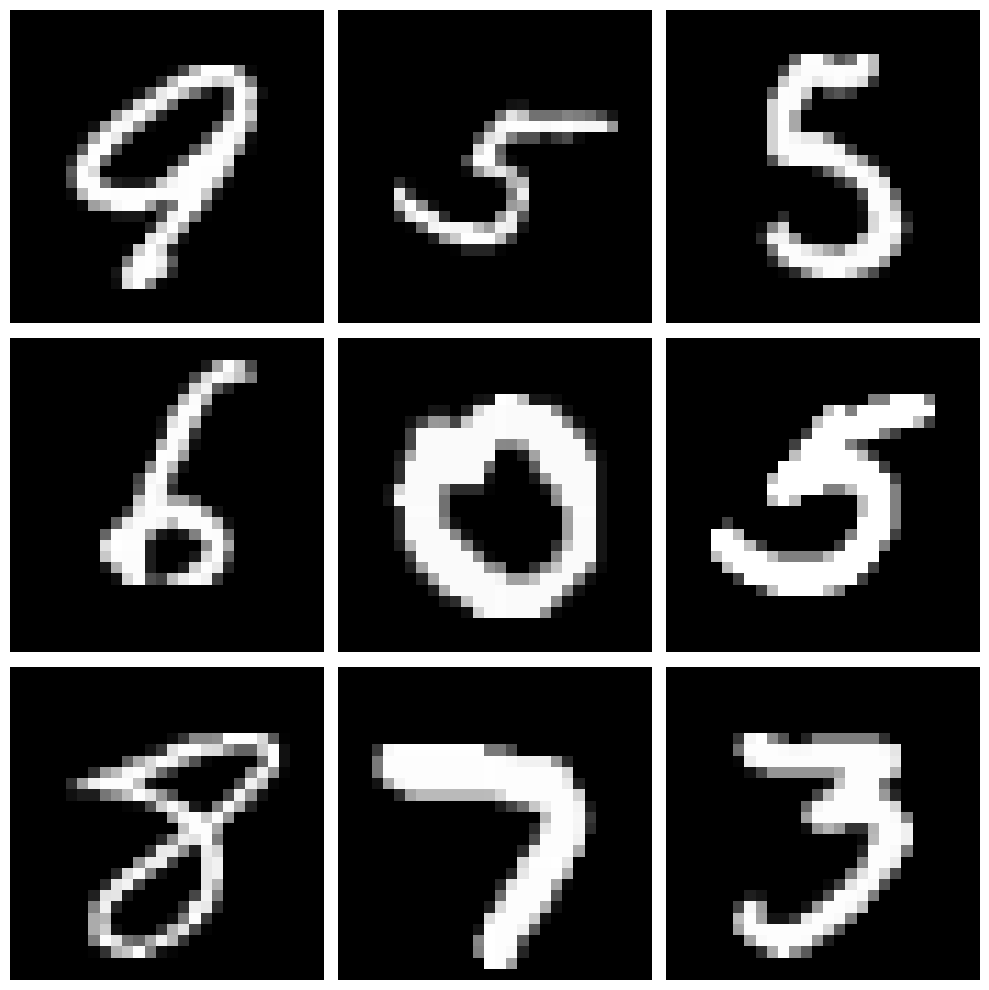

In [4]:
def get_dataloaders(batch_size: int = 128, num_workers=0, input_transform : transforms.Compose = transforms.Compose([])):
    #transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((1,), (1,))])
    transform = transforms.Compose([transforms.ToTensor(), input_transform])
    trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(trainset))
    train_size = len(trainset) - val_size
    trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    return trainloader, valloader, testloader

# plot the images
trainloader, valloader, testloader = get_dataloaders()
images, labels = next(iter(trainloader))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    #print(torch.min(images[i]))
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [56]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 2, image_size: int = 28):
        super().__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices = True)
        self.unpool = nn.MaxUnpool2d(2, stride=2)
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        
        self.encoder_linear = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.Flatten(),
            nn.Linear(8 * image_size * image_size , 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_dim),
        )
        
        
        self.decoder_linear = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 8 * image_size * image_size),
            nn.Unflatten(1, torch.Size([32, int(image_size/2), int(image_size/2)])),

        )

    def forward(self, x):
        x, indicies1 = self.pool(self.conv1(x))     
        x = self.conv2(x)   
        encoded = self.encoder_linear(x)
        z = self.decoder_linear(encoded)
        z = self.unpool(self.conv_transpose1(z), indicies1)    
        decoded = torch.sigmoid(self.conv_transpose2(z))   
        
        return decoded

In [57]:
model = ConvAutoEncoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=run_wandb.config["lr"])
trainloader, valloader, testloader = get_dataloaders(batch_size=run_wandb.config["batch_size"], num_workers=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(run_wandb.config["epoch"]):
    model.train()
    model.to(device)
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    run_wandb.log({"loss": running_loss / len(trainloader)})
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

Epoch 1, Loss: 0.19143289026427776
Epoch 2, Loss: 0.12229199992849472
Epoch 3, Loss: 0.10499330863673637
Epoch 4, Loss: 0.09810510586867942
Epoch 5, Loss: 0.09479570341237048
Epoch 6, Loss: 0.09236774086318117
Epoch 7, Loss: 0.09059721231460571
Epoch 8, Loss: 0.08907365854433243
Epoch 9, Loss: 0.08814140298265091
Epoch 10, Loss: 0.08752252383435026
Epoch 11, Loss: 0.08704607529526061
Epoch 12, Loss: 0.08664285676910523
Epoch 13, Loss: 0.08618421947702448
Epoch 14, Loss: 0.08557024923093776
Epoch 15, Loss: 0.08552384083258345
Epoch 16, Loss: 0.08564541251101393
Epoch 17, Loss: 0.08532501852258723
Epoch 18, Loss: 0.08536219240186062
Epoch 19, Loss: 0.08498613116271952
Epoch 20, Loss: 0.08498128757197806
Epoch 21, Loss: 0.08505184464949242
Epoch 22, Loss: 0.08474005497199424
Epoch 23, Loss: 0.08466586010887268
Epoch 24, Loss: 0.08471301515051659
Epoch 25, Loss: 0.08462493185033189
Epoch 26, Loss: 0.08461985380408611
Epoch 27, Loss: 0.08456137277027394
Epoch 28, Loss: 0.08428984912151986
E

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


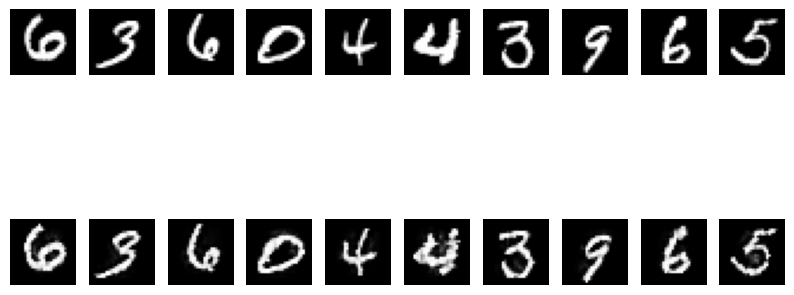

In [58]:
with torch.no_grad():
    images, _ = next(iter(trainloader))
    images = images.to(device)
    outputs = model(images)
    
    # Plot original and reconstructed images
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].reshape(28, 28).detach().cpu(), cmap='gray')
        plt.axis('off')
        plt.subplot(2, 10, i + 11)
        plt.imshow(outputs[i].reshape(28, 28).detach().cpu(), cmap='gray')
        plt.axis('off')
    plt.show()
    

## Вариативные автоэнкодеры (35%)

![img](https://www.researchgate.net/publication/365190062/figure/fig2/AS:11431281095388874@1667878234857/Structure-of-the-conditional-variational-autoencoder-CVAE.png)

Воспользуйтесь кодом из семинара (либо конволюционными автоэнкодером из прошого задания) и добавьте условия на вариативные автоэнкодеры.

1. В качестве условия используйте метки классов.
2. В энкодер и декодер добавьте условия на метки классов.


Проверьте качество модели и сравните с обычным вариативным автоэнкодером.

In [4]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 2, num_classes: int = 10, image_size: int = 28):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.image_size = 28
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        # encoder part
        self.encode1 = nn.Linear(self.image_size * self.image_size + self.num_classes, 512)
        self.encode2 = nn.Linear(512, 256)
        self.encode_mu = nn.Linear(256, self.hidden_dim)
        self.encode_logvar = nn.Linear(256, self.hidden_dim)
        # decoder part
        self.decode1 = nn.Linear(self.hidden_dim + self.num_classes, 256)
        self.decode2 = nn.Linear(256, 512)
        self.decode3 = nn.Linear(512, self.image_size * self.image_size)

    def encoder(self, x, y):
        
        
        #print (x.shape, c.shape)
        z = torch.cat([x, y], dim = 1)
        h = F.relu(self.encode1(z))
        h = F.relu(self.encode2(h))
        return self.encode_mu(h), self.encode_logvar(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # logvar -> std
        eps = torch.randn_like(std)  # noise
        return mu + eps * std

    def decoder(self, z, y):

        h = F.relu(self.decode1(torch.cat([z, y],dim=1)))
        h = F.relu(self.decode2(h))
        return torch.tanh(self.decode3(h))

    def forward(self, x, y):
        
        x = x.view(-1, self.image_size * self.image_size)
        c = self.label_emb(y)
        #print(y)
        mu, log_var = self.encoder(x, c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

    def generate(self, num_samples):
        z = torch.randn(num_samples, self.hidden_dim, device=self.device)
        return self.decoder(z, z)


def loss_function(recon_x, x, mu, log_var, image_size:int = 28, num_classes:int = 10):
    BCE = F.mse_loss(recon_x, x.view(-1, image_size * image_size), reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:
wandb_config = {
    "epoch": 100, 
    "lr": 1e-3, 
    "batch_size": 512
    ,}
      
run_wandb = wandb.init(project="hw-08-VAE", 
        notes="Dataset Name MINST" , 
        tags=["baseline", "VAE", "MINST"], 
        config=wandb_config,
)

wandb: Currently logged in as: andrei-simkin (an4sim). Use `wandb login --relogin` to force relogin


In [6]:
num_classes = 10

model = VariationalAutoEncoder(hidden_dim=2, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=run_wandb.config["lr"])
trainloader, valloader, testloader = get_dataloaders(batch_size=run_wandb.config["batch_size"], num_workers=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(run_wandb.config["epoch"]):
    model.train()
    model.to(device)
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        #labels_oh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
        optimizer.zero_grad()
        outputs, mu, logsigma = model(inputs, labels)
        
        loss = loss_function(outputs, inputs, mu, logsigma)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    run_wandb.log({"loss": running_loss / len(trainloader)})
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1, Loss: 23393.496976811835
Epoch 2, Loss: 19231.36625249335
Epoch 3, Loss: 17726.805258892953
Epoch 4, Loss: 17042.786080867685
Epoch 5, Loss: 16623.08800490359
Epoch 6, Loss: 16368.239725315825
Epoch 7, Loss: 16185.409314744016
Epoch 8, Loss: 16052.938424617687
Epoch 9, Loss: 15940.249989611037
Epoch 10, Loss: 15858.99714303524
Epoch 11, Loss: 15778.479035073138
Epoch 12, Loss: 15699.405844830451
Epoch 13, Loss: 15640.564577792553
Epoch 14, Loss: 15580.917023354388
Epoch 15, Loss: 15528.521432430187
Epoch 16, Loss: 15479.17787982048
Epoch 17, Loss: 15433.769593583776
Epoch 18, Loss: 15385.685339095744
Epoch 19, Loss: 15355.508737117687
Epoch 20, Loss: 15302.999075382313
Epoch 21, Loss: 15279.911028922872
Epoch 22, Loss: 15235.042719414894
Epoch 23, Loss: 15214.36376953125
Epoch 24, Loss: 15173.025349069148
Epoch 25, Loss: 15150.003023188165
Epoch 26, Loss: 15128.253729637632
Epoch 27, Loss: 15106.858762051197
Epoch 28, Loss: 15083.012300531915
Epoch 29, Loss: 15048.016206781915

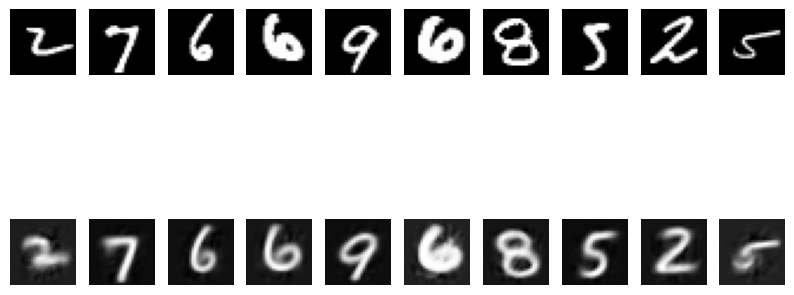

In [7]:
import matplotlib.pyplot as plt
with torch.no_grad():
    images, labels = next(iter(trainloader))
    model.to('cpu')
    outputs = model(images, labels)

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].reshape(28, 28).detach().cpu(), cmap='gray')
        plt.axis('off')
        plt.subplot(2, 10, i + 11)
        plt.imshow(outputs[0][i].reshape(28, 28).detach().cpu(), cmap='gray')
        plt.axis('off')
    plt.show()


In [8]:
def plot_reconstructed(model, r0=(-3, 3), r1=(-3, 3),
                             n=8, number=2):
    
    fig, axs = plt.subplots(n, n)
    device = "cpu"
    
    for i, a in enumerate(np.linspace(*r1, n)):
        for j, b in enumerate(np.linspace(*r0, n)):
           
            z = torch.Tensor([[a, b]]).to(device)
            y = model.label_emb(torch.tensor([number]).to(device))
            x_hat = model.decoder(z, y)
           
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            
            axs[i, j].imshow(x_hat, cmap='gray')
            axs[i, j].axis('off')
    plt.show()

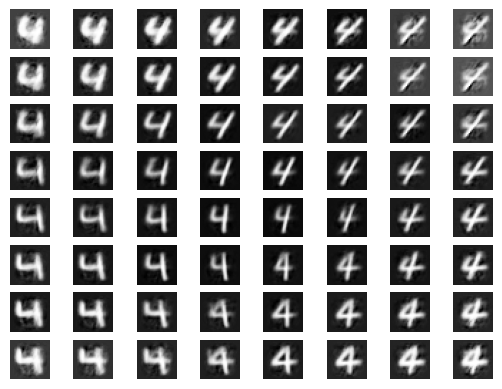

In [9]:
plot_reconstructed(model, number=4)

## GAN с условием (35%)

Воспользуйтесь кодом из семинара и добавьте условия на GAN модели.

1. В качестве условия используйте метки классов.
2. В генератор и дискриминатор добавьте условия на метки классов.

Проверьте качество модели и сравните с остальными моделями. Какую модель вы бы выбрали для работы с генерацией картинок MNIST и почему?

Для работы с генерацией картинок MNIST я бы выбрал VAE - достаточно просто создать + обучение модели идет быстро.

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, input_dim:int=100, hidden_dim:int = 256, output_dim:int = 28 * 28, class_num:int = 10):
        super().__init__()
        self.class_num = class_num
        #self.label_emb = nn.Embedding(self.class_num, self.class_num)
        self.main = nn.Sequential(
            nn.Linear(input_dim + self.class_num, hidden_dim),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.Tanh(),
            #nn.Sigmoid(),
        )

    def forward(self, noise, y):
        #c = self.label_emb(y)      
        c = F.one_hot(y)
        x = torch.cat([noise, c], dim = 1)
        
        return self.main(x).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self, input_dim:int=28 * 28, hidden_dim:int=512, class_num:int = 10):
        super().__init__()
        self.class_num = class_num
        #self.label_emb = nn.Embedding(self.class_num, self.class_num)
        self.main = nn.Sequential(
            nn.Linear(input_dim + self.class_num, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace = True),  # LeakyReLU is common in GANs
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
            #nn.Tanh(),  # Output probability of real/fake
        )

    def forward(self, image:torch.Tensor, y):
        #c = self.label_emb(y)
        c = F.one_hot(y)
        return self.main(torch.cat([image.view(-1, 28 * 28), c], dim = 1))  # Flatten input

torch.Size([128, 100]) torch.Size([128])


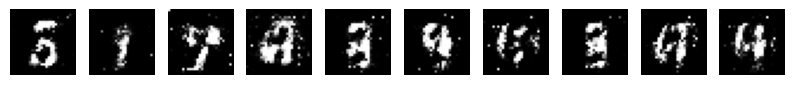

Epoch [10/200], D_Loss: 0.5705, G_Loss: 2.0763
torch.Size([128, 100]) torch.Size([128])


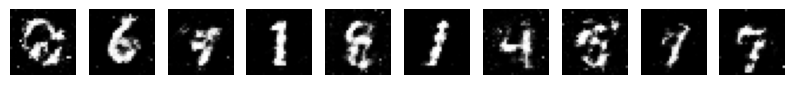

Epoch [20/200], D_Loss: 0.9640, G_Loss: 1.6855
torch.Size([128, 100]) torch.Size([128])


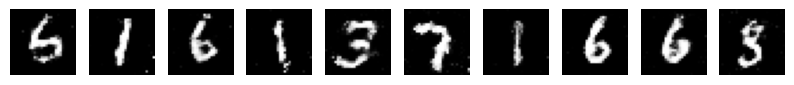

Epoch [30/200], D_Loss: 1.1355, G_Loss: 1.0418
torch.Size([128, 100]) torch.Size([128])


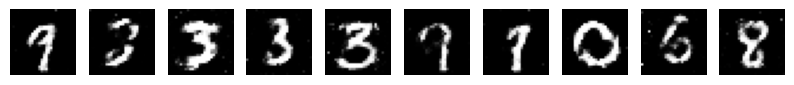

Epoch [40/200], D_Loss: 1.2798, G_Loss: 0.9894
torch.Size([128, 100]) torch.Size([128])


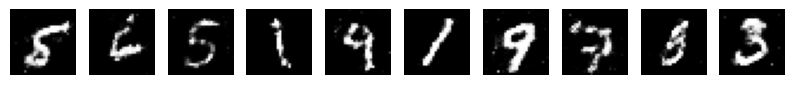

Epoch [50/200], D_Loss: 1.2233, G_Loss: 0.9618
torch.Size([128, 100]) torch.Size([128])


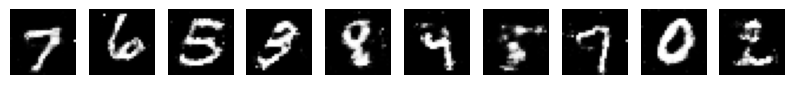

Epoch [60/200], D_Loss: 1.2546, G_Loss: 0.8338
torch.Size([128, 100]) torch.Size([128])


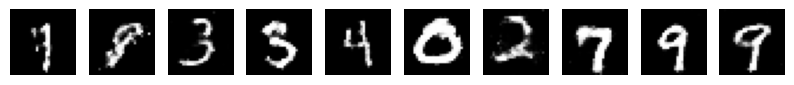

Epoch [70/200], D_Loss: 1.3128, G_Loss: 0.8243
torch.Size([128, 100]) torch.Size([128])


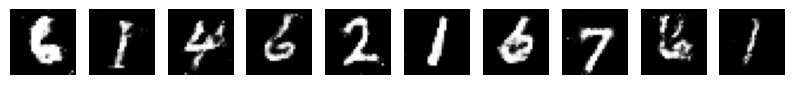

Epoch [80/200], D_Loss: 1.2724, G_Loss: 0.8184
torch.Size([128, 100]) torch.Size([128])


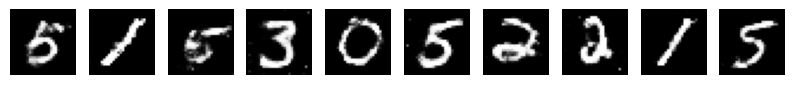

Epoch [90/200], D_Loss: 1.3043, G_Loss: 0.8859
torch.Size([128, 100]) torch.Size([128])


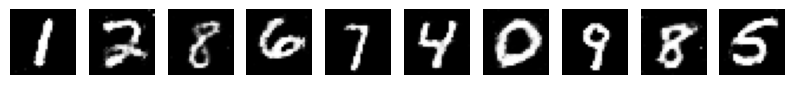

Epoch [100/200], D_Loss: 1.3093, G_Loss: 0.8282
torch.Size([128, 100]) torch.Size([128])


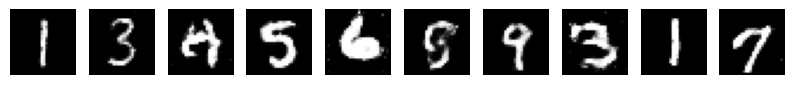

Epoch [110/200], D_Loss: 1.3370, G_Loss: 0.7583
torch.Size([128, 100]) torch.Size([128])


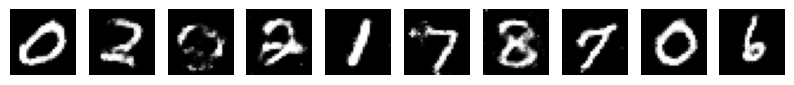

Epoch [120/200], D_Loss: 1.3336, G_Loss: 0.8070
torch.Size([128, 100]) torch.Size([128])


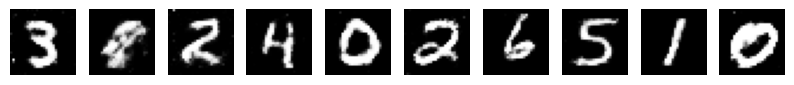

Epoch [130/200], D_Loss: 1.3624, G_Loss: 0.8004
torch.Size([128, 100]) torch.Size([128])


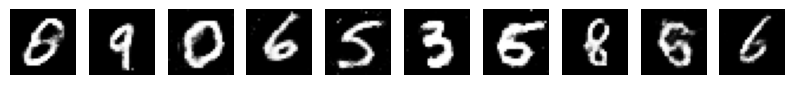

Epoch [140/200], D_Loss: 1.2592, G_Loss: 0.9235
torch.Size([128, 100]) torch.Size([128])


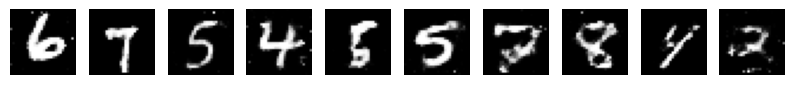

Epoch [150/200], D_Loss: 1.3215, G_Loss: 0.7837
torch.Size([128, 100]) torch.Size([128])


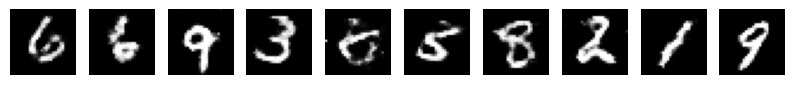

Epoch [160/200], D_Loss: 1.3244, G_Loss: 0.8243
torch.Size([128, 100]) torch.Size([128])


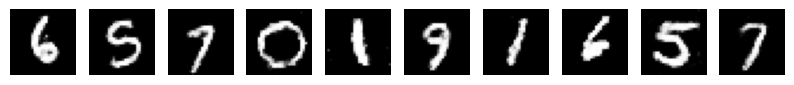

Epoch [170/200], D_Loss: 1.2793, G_Loss: 0.8267
torch.Size([128, 100]) torch.Size([128])


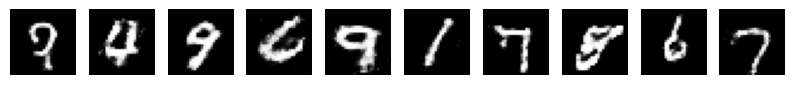

Epoch [180/200], D_Loss: 1.3276, G_Loss: 0.8544
torch.Size([128, 100]) torch.Size([128])


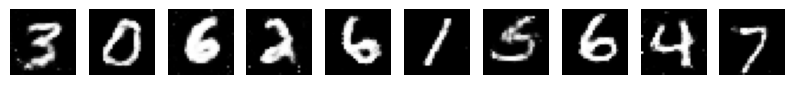

Epoch [190/200], D_Loss: 1.2943, G_Loss: 0.8411
torch.Size([128, 100]) torch.Size([128])


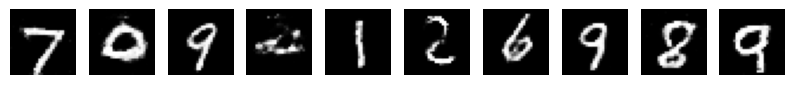

Epoch [200/200], D_Loss: 1.2323, G_Loss: 0.8932


In [87]:
wandb_config = {
    "epoch": 200, 
    "G_lr": 0.00025, 
    "D_lr": 0.0001,
    "G_weight_decay": 5e-5,
    "D_weight_decay": 5e-5,
    "betas": (0.5, 0.999),
    "batch_size": 512
    ,}
      
run_wandb = wandb.init(project="hw-08-GAN", 
        notes="Dataset Name MINST" , 
        tags=["baseline", "GAN", "MINST"], 
        config=wandb_config,
        #settings=wandb.Settings(start_method="fork"),
)

trainloader, valloader, testloader = get_dataloaders(input_transform = transforms.Compose([transforms.Normalize(mean=(0.499, ),std=(0.499,))]))
#trainloader, valloader, testloader = get_dataloaders()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
class_num = 10

# возможно стоит поиграть с гиперпараметрами
#optimizer_G = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
#optimizer_D = optim.Adam(discriminator.parameters(), lr=5e-3, betas=(0.5, 0.999))

optimizer_G = optim.AdamW(generator.parameters(), lr=run_wandb.config["G_lr"], betas=run_wandb.config["betas"], weight_decay = run_wandb.config["G_weight_decay"])
optimizer_D = optim.AdamW(discriminator.parameters(), lr=run_wandb.config["D_lr"], betas=run_wandb.config["betas"], weight_decay = run_wandb.config["D_weight_decay"])


EPOCHS = run_wandb.config["epoch"]
#EPOCHS = 200
for epoch in range(EPOCHS):
    for real_images, labels in trainloader:
        
        real_images = real_images.to(device)
        labels = labels.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        fake_pass_labels = torch.randint(low=0, high = class_num, size = (batch_size,1)).squeeze(1).to(device)

        real_output = discriminator(real_images, labels)
        #print(real_output)
        d_loss_real = criterion(real_output, real_labels)
        d_loss_real.backward()

        noise = torch.randn(batch_size, 100).to(device)
        #print(noise.shape, fake_pass_labels.shape)
        fake_images = generator(noise, fake_pass_labels)
        fake_output = discriminator(fake_images.detach(), fake_pass_labels)
        #print(fake_output.shape, fake_labels.shape)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss_fake.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_images, fake_pass_labels)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()
        
    run_wandb.log({"D_Loss": d_loss_real.item() + d_loss_fake.item(), "G_Loss": g_loss.item()})
    if (epoch + 1) % 10 == 0:
        
        test_batch_size = 128 
        
        z_images = torch.randn(test_batch_size , 100).to(device)
        check_labels = torch.randint(low=0, high = class_num, size = (test_batch_size ,1)).squeeze(1).to(device)

        with torch.no_grad():
            fake_images = generator(z_images, check_labels).detach().cpu()
        plt.figure(figsize=(10, 2))
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(fake_images[i][0], cmap="gray")
            plt.axis("off")
        plt.show()
        print(
            f"Epoch [{epoch+1}/{EPOCHS}], D_Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G_Loss: {g_loss.item():.4f}"
        )

## Решил ДЗ - дай обратную связь ;)

Надеемся, было интересно и полезно.

Пожалуйста, оставьте обратную связь по этому домашнему заданию: https://forms.gle/iY5NRn9UfaZ344rbA